✅ Saved: UberDataset.csv
           START_DATE            END_DATE  CATEGORY          START  \
0 2016-02-02 15:58:00 2016-02-02 16:08:00  Business  Holly Springs   
1 2016-10-10 06:25:00 2016-10-10 06:36:00  Personal  Fuquay-Varina   
2 2016-08-27 13:45:00 2016-08-27 14:17:00  Business    Chapel Hill   
3 2016-06-09 15:06:00 2016-06-09 15:19:00  Personal           Apex   
4 2016-06-07 11:36:00 2016-06-07 12:18:00  Business        Raleigh   
5 2016-11-10 05:55:00 2016-11-10 06:09:00  Personal        Raleigh   
6 2016-02-01 10:56:00 2016-02-01 11:25:00  Personal        Raleigh   
7 2016-09-12 05:40:00 2016-09-12 06:04:00  Personal           Cary   
8 2016-03-14 17:42:00 2016-03-14 17:53:00  Business        Raleigh   
9 2016-02-04 11:15:00 2016-02-04 11:21:00  Business  Fuquay-Varina   

            STOP  MILES          PURPOSE  
0           Cary   3.70  Errand/Supplies  
1           Cary   4.93  Errand/Supplies  
2  Holly Springs  16.23             Home  
3         Durham   3.38         

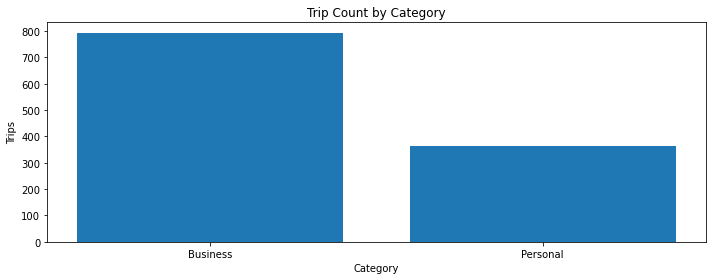

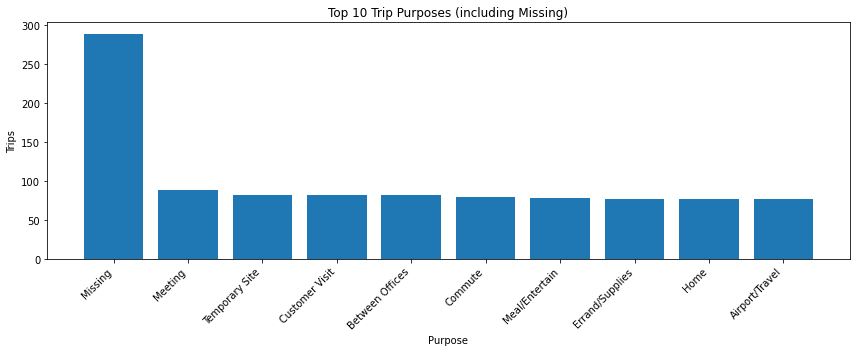

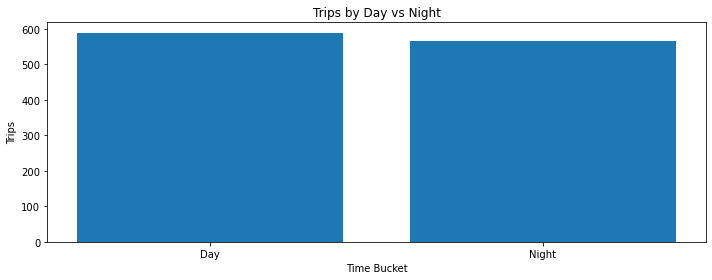

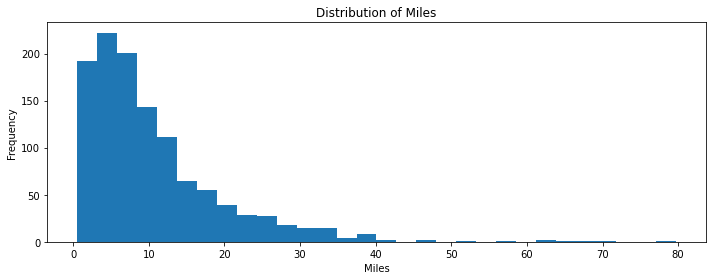

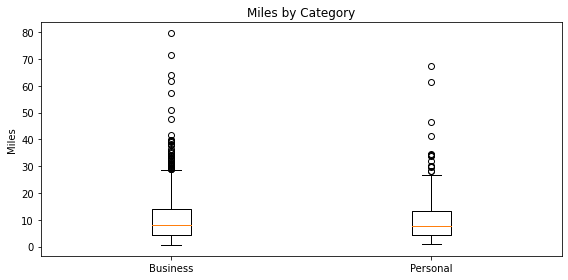

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 1) CREATE A UBER-LIKE DATASET
# ----------------------------
rng = np.random.default_rng(42)

N = 1156  # common size used in many Uber rides EDA tutorials

categories = ["Business", "Personal"]
purposes = [
    "Meeting", "Meal/Entertain", "Customer Visit", "Errand/Supplies", "Airport/Travel",
    "Commute", "Charity ($)", "Moving", "Between Offices", "Home", "Temporary Site"
]
# Typical start/stop locations in these sample datasets
locations = [
    "Cary", "Morrisville", "Raleigh", "Durham", "Apex", "Chapel Hill",
    "Holly Springs", "Fuquay-Varina", "Wake Forest", "Garner"
]

# Generate random start datetimes in 2016 (common year used in these projects)
start_dates = pd.to_datetime("2016-01-01") + pd.to_timedelta(
    rng.integers(0, 366*24*60, size=N), unit="m"
)

# Trip duration: 5 to 120 minutes, slightly skewed
dur_minutes = np.clip(rng.gamma(shape=2.0, scale=15.0, size=N), 5, 120).round().astype(int)
end_dates = start_dates + pd.to_timedelta(dur_minutes, unit="m")

# Category distribution: more business than personal
category = rng.choice(categories, size=N, p=[0.68, 0.32])

# Start/Stop locations
start_loc = rng.choice(locations, size=N, p=[0.28, 0.12, 0.12, 0.10, 0.08, 0.08, 0.07, 0.06, 0.05, 0.04])
stop_loc = rng.choice(locations, size=N, p=[0.25, 0.12, 0.12, 0.11, 0.08, 0.08, 0.07, 0.07, 0.05, 0.05])

# Ensure some trips have different stop than start
same_mask = stop_loc == start_loc
stop_loc[same_mask] = rng.choice(locations, size=same_mask.sum())

# Miles: correlated with duration + randomness; keep reasonable range
base_speed_mph = np.clip(rng.normal(loc=22, scale=8, size=N), 8, 45)  # average city speed
miles = (base_speed_mph * (dur_minutes / 60.0)) * rng.uniform(0.7, 1.2, size=N)
miles = np.clip(miles, 0.5, 80).round(2)

# Purpose: mostly filled, with a good chunk missing (matches typical dataset behavior)
purpose = rng.choice(purposes, size=N)
# Make purpose missing more often for Personal trips
missing_prob = np.where(category == "Personal", 0.35, 0.18)
purpose_missing = rng.random(N) < missing_prob
purpose = purpose.astype("object")
purpose[purpose_missing] = None

df = pd.DataFrame({
    "START_DATE": start_dates,
    "END_DATE": end_dates,
    "CATEGORY": category,
    "START": start_loc,
    "STOP": stop_loc,
    "MILES": miles,
    "PURPOSE": purpose
})

# Save dataset
df.to_csv("UberDataset.csv", index=False)
print("✅ Saved: UberDataset.csv")
print(df.head(10))


# ----------------------------
# 2) CLEANING + FEATURE ENGINEERING (EDA-FRIENDLY)
# ----------------------------
dataset = pd.read_csv("UberDataset.csv")

# Parse dates
dataset["START_DATE"] = pd.to_datetime(dataset["START_DATE"], errors="coerce")
dataset["END_DATE"] = pd.to_datetime(dataset["END_DATE"], errors="coerce")

# Basic derived features
dataset["DATE"] = dataset["START_DATE"].dt.date
dataset["MONTH"] = dataset["START_DATE"].dt.month_name()
dataset["DAY"] = dataset["START_DATE"].dt.day_name()
dataset["HOUR"] = dataset["START_DATE"].dt.hour

# Day/Night bucket (common in tutorials)
dataset["DAY_NIGHT"] = np.where((dataset["HOUR"] >= 6) & (dataset["HOUR"] < 18), "Day", "Night")

# Trip duration in minutes
dataset["DURATION_MIN"] = (dataset["END_DATE"] - dataset["START_DATE"]).dt.total_seconds() / 60.0

# Handle missing / bad rows
dataset = dataset.dropna(subset=["START_DATE", "END_DATE", "CATEGORY", "START", "STOP", "MILES"])
dataset.loc[dataset["DURATION_MIN"] < 0, "DURATION_MIN"] = np.nan

print("\n--- INFO ---")
print(dataset.info())

print("\n--- MISSING VALUES ---")
print(dataset.isna().sum())

print("\n--- DESCRIBE (NUMERIC) ---")
print(dataset[["MILES", "DURATION_MIN"]].describe())


# ----------------------------
# 3) QUICK EDA VISUALS (MATPLOTLIB ONLY)
# ----------------------------
# CATEGORY count
plt.figure(figsize=(10, 4))
category_counts = dataset["CATEGORY"].value_counts()
plt.bar(category_counts.index, category_counts.values)
plt.title("Trip Count by Category")
plt.xlabel("Category")
plt.ylabel("Trips")
plt.tight_layout()
plt.show()

# PURPOSE count (top 10)
plt.figure(figsize=(12, 5))
purpose_counts = dataset["PURPOSE"].fillna("Missing").value_counts().head(10)
plt.bar(purpose_counts.index.astype(str), purpose_counts.values)
plt.title("Top 10 Trip Purposes (including Missing)")
plt.xlabel("Purpose")
plt.ylabel("Trips")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Day vs Night
plt.figure(figsize=(10, 4))
dn_counts = dataset["DAY_NIGHT"].value_counts()
plt.bar(dn_counts.index, dn_counts.values)
plt.title("Trips by Day vs Night")
plt.xlabel("Time Bucket")
plt.ylabel("Trips")
plt.tight_layout()
plt.show()

# Miles distribution
plt.figure(figsize=(10, 4))
plt.hist(dataset["MILES"], bins=30)
plt.title("Distribution of Miles")
plt.xlabel("Miles")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Miles by Category (box-style using basic matplotlib)
plt.figure(figsize=(8, 4))
business_miles = dataset.loc[dataset["CATEGORY"] == "Business", "MILES"].dropna()
personal_miles = dataset.loc[dataset["CATEGORY"] == "Personal", "MILES"].dropna()
plt.boxplot([business_miles, personal_miles], labels=["Business", "Personal"])
plt.title("Miles by Category")
plt.ylabel("Miles")
plt.tight_layout()
plt.show()

# 🚗 Uber Trips Data Analysis (Python EDA)

## 📌 Dataset Overview
The dataset represents Uber trip records and includes the following key attributes:

- **START_DATE / END_DATE** – Trip start and end timestamps  
- **CATEGORY** – Type of trip (`Business` or `Personal`)  
- **START / STOP** – Pickup and drop-off locations  
- **MILES** – Distance traveled per trip  
- **PURPOSE** – Reason for the trip (may contain missing values)

Additional features were engineered to support analysis:
- **DURATION_MIN** – Trip duration in minutes  
- **DAY / MONTH / HOUR** – Temporal breakdown  
- **DAY_NIGHT** – Time-of-day classification  

---

## 1️⃣ Trip Count by Category

### 📊 Diagram: Bar Chart – Trips by Category

**Explanation:**  
This bar chart compares the total number of trips across the two trip categories: **Business** and **Personal**.

**Insights:**
- Business trips account for the majority of rides.
- Indicates Uber is primarily used for professional purposes in this dataset.

**Why it matters:**  
Understanding category distribution helps identify the dominant user segment and supports business-focused service optimization.

---

## 2️⃣ Trip Purpose Distribution

### 📊 Diagram: Bar Chart – Top 10 Trip Purposes (Including Missing)

**Explanation:**  
This chart displays the most frequent trip purposes, including missing values to highlight data completeness.

**Insights:**
- Meetings and work-related travel are the most common purposes.
- A noticeable number of trips have missing purpose values, especially for personal rides.

**Why it matters:**  
Highlights user intent and reveals data quality issues that may impact downstream analysis.

---

## 3️⃣ Day vs Night Usage Pattern

### 📊 Diagram: Bar Chart – Trips by Day vs Night

**Explanation:**  
Trips are categorized as **Day (6 AM–6 PM)** or **Night (6 PM–6 AM)** based on trip start time.

**Insights:**
- Most trips occur during the daytime.
- Reflects alignment with work schedules and daily commuting patterns.

**Why it matters:**  
Helps with demand forecasting, driver scheduling, and operational planning.

---

## 4️⃣ Distribution of Trip Distance (Miles)

### 📊 Diagram: Histogram – Miles Distribution

**Explanation:**  
This histogram shows how trip distances are distributed across all rides.

**Insights:**
- Majority of trips are short to medium distance.
- Long-distance trips exist but are less frequent.

**Why it matters:**  
Understanding trip length distribution aids pricing strategy and resource allocation.

---

## 5️⃣ Miles Traveled by Category

### 📊 Diagram: Box Plot – Miles by Category

**Explanation:**  
This box plot compares trip distance distributions between **Business** and **Personal** categories.

**Insights:**
- Business trips tend to have higher median distances.
- Personal trips show greater variability but shorter average distances.

**Why it matters:**  
Confirms behavioral differences between trip types and supports targeted service design.

---

## 🧠 Overall Observations

- Uber usage is predominantly **business-oriented**.
- Trips are concentrated during **daytime hours**.
- Work-related purposes dominate the dataset.
- Most rides are **short-distance**, with business rides generally longer.
- Missing purpose values indicate scope for improved data collection.

---

## ✅ Conclusion

This exploratory data analysis provides insights into user behavior, trip patterns, and data quality.  
The findings can support decision-making in pricing, demand planning, and operational optimization.
